In [37]:
# Import needed libraries 

import pandas as pd 
import os
import datetime
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc
from dotenv import load_dotenv
from itertools import islice
from pandas .tseries.offsets import DateOffset

#Import various libraries needed to train and test ML models
from keras.datasets import imdb
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing import sequence
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [38]:
# Load .env file

load_dotenv()

True

In [39]:
# Set Alpaca API key and secret
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")


# Create the Alpaca API object
api = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2",
    base_url= ALPACA_ENDPOINT_KEY
)

In [40]:
# Parameters for Stock Data from Alpacas
# Establish time frame (5 minute)

time_frame = "5min"

# Identify what stock symbol is trading

stock_symbol = "QQQ"

# Identify what start date to begin data analysis

start_date = pd.Timestamp("2021-02-01", tz="America/New_York").isoformat()

# Identify what end date to finalize data analysis

end_date = pd.Timestamp("2022-07-31", tz="America/New_York").isoformat()

In [41]:
# Function to call daily stock data

def get_stock_data(api, stock_symbol, time_frame, start_date, end_date):
    
    # Assuming api.get_bars returns a DataFrame with a 'df' attribute
    
    stock_data = api.get_bars(
        stock_symbol, 
        time_frame, 
        start=start_date, 
        end=end_date
        ).df
    return stock_data

stock_data = get_stock_data(api, stock_symbol, time_frame, start_date, end_date)

# Displays the information pulled for working through code

stock_data.info()
display(stock_data.head())
display(stock_data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69968 entries, 2021-02-01 09:00:00+00:00 to 2022-07-29 21:55:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        69968 non-null  float64
 1   high         69968 non-null  float64
 2   low          69968 non-null  float64
 3   trade_count  69968 non-null  int64  
 4   open         69968 non-null  float64
 5   volume       69968 non-null  int64  
 6   vwap         69968 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 4.3 MB


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-02-01 09:00:00+00:00,317.78,317.79,317.26,457,317.62,152785,317.615546
2021-02-01 09:05:00+00:00,317.63,317.79,317.54,42,317.75,5968,317.621602
2021-02-01 09:10:00+00:00,317.85,317.90,317.65,41,317.65,5138,317.836724
2021-02-01 09:15:00+00:00,318.15,318.25,317.97,77,318.00,18913,318.110307
2021-02-01 09:20:00+00:00,318.01,318.33,318.00,88,318.11,20816,318.259888


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2022-07-29 21:35:00+00:00,315.38,315.38,315.37,55,315.37,4611,315.378556
2022-07-29 21:40:00+00:00,315.37,315.37,315.33,27,315.33,4376,315.333291
2022-07-29 21:45:00+00:00,315.39,315.39,315.25,55,315.35,7351,315.336486
2022-07-29 21:50:00+00:00,315.25,315.31,315.25,37,315.31,4749,315.300913
2022-07-29 21:55:00+00:00,315.28,315.28,315.27,14,315.27,451,315.271652


In [42]:
# Function to prepare daily stock data to identify double top/bottom patterns and prepare for targets
# Includes establishing a polynomial fit and assigning new columns for localized min/max

# Polynomial Degree

polynomial_degree = 25

def polynomial_min_max_fit(stock_data, polynomial_degree):
    
    min_length = len(stock_data.index)
    x_data = np.arange(min_length)

    # Polynomial fitting
    polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
    polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
    polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
    polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)

    # Evaluate the polynomial fit for plotting
    y_polynomial_open = np.polyval(polynomial_coefficients_open, x_data)
    y_polynomial_high = np.polyval(polynomial_coefficients_high, x_data)
    y_polynomial_low = np.polyval(polynomial_coefficients_low, x_data)
    y_polynomial_close = np.polyval(polynomial_coefficients_close, x_data)

    # Identify local extrema for polynomial fit data (minima and maxima)
    local_poly_minima = argrelextrema(y_polynomial_close, np.less, order=5)[0]
    local_poly_maxima = argrelextrema(y_polynomial_close, np.greater, order=5)[0]

    # Convert the close price polynomial fit data into a dataframe
    # This is done for OHLC poly fit data

    poly_df = pd.DataFrame(y_polynomial_open)
    columns = ['poly_fit_open']
    poly_df.columns = columns
    poly_df = poly_df.assign(poly_fit_high = y_polynomial_high)
    poly_df = poly_df.assign(poly_fit_low = y_polynomial_low)
    poly_df = poly_df.assign(poly_fit_close = y_polynomial_close)

    # Reset the index of the original updated ticker dataframe to concat with the polynomial dataframe that does not include a timeseries
    # This will ensure that the indexed intergers of the ploynomial fit align with the time each data point corresponds to

    updated_stock_data = stock_data.reset_index()
    updated_stock_data = pd.concat([updated_stock_data, poly_df], axis='columns', join='inner')
    updated_stock_data.head()

    # Add minima and maxima column to the DataFrame

    updated_stock_data["minima"] = 0
    updated_stock_data["maxima"] = 0
    updated_stock_data.head()

    # Mark rows with local minima as 1 in the 'minima' column

    for index in local_poly_minima:
        updated_stock_data.at[index, 'minima'] = -1

    for index in local_poly_maxima:
        updated_stock_data.at[index, "maxima"] = 1

    # Create Target Columns - Double Top Target & Double Bottom Target
        
    updated_stock_data["dbl_top_target"] = 0
    updated_stock_data["dbl_bot_target"] = 0

   
    return updated_stock_data

# For data checking/confirmation
updated_stock_data = polynomial_min_max_fit(stock_data,polynomial_degree)
updated_stock_data.head()

C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:14: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:15: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:16: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:17: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2021-02-01 09:00:00+00:00,317.78,317.79,317.26,457,317.62,152785,317.615546,306.628753,306.887312,306.377215,306.637989,0,0,0,0
1,2021-02-01 09:05:00+00:00,317.63,317.79,317.54,42,317.75,5968,317.621602,306.698227,306.956335,306.447103,306.707461,0,0,0,0
2,2021-02-01 09:10:00+00:00,317.85,317.90,317.65,41,317.65,5138,317.836724,306.767600,307.025259,306.516890,306.776832,0,0,0,0
3,2021-02-01 09:15:00+00:00,318.15,318.25,317.97,77,318.00,18913,318.110307,306.836874,307.094083,306.586576,306.846104,0,0,0,0
4,2021-02-01 09:20:00+00:00,318.01,318.33,318.00,88,318.11,20816,318.259888,306.906046,307.162807,306.656161,306.915275,0,0,0,0


C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2995550416.py:11: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)


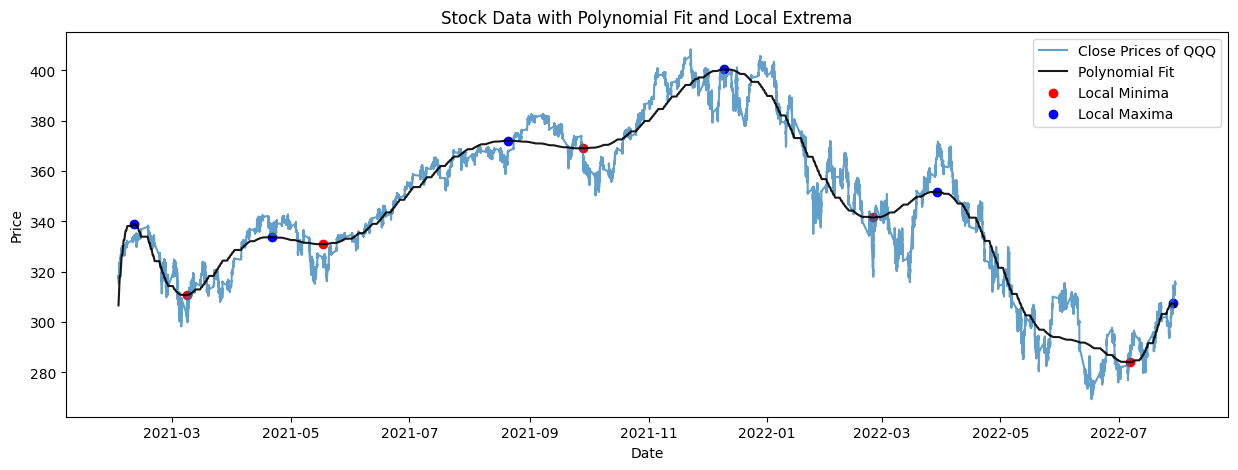

In [43]:
# Plot data
# Plot the stock data and identified minima

plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data["close"], label='Close Prices of QQQ', alpha=0.7)

# # Plot polynomial fit

min_length = len(stock_data.index)
x_data = np.arange(min_length)
polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)
y_polynomial_close = np.polyval(polynomial_coefficients_close, x_data)
local_poly_minima = argrelextrema(y_polynomial_close, np.less, order=5)[0]
local_poly_maxima = argrelextrema(y_polynomial_close, np.greater, order=5)[0]


plt.plot(stock_data.index[:min_length], y_polynomial_close, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# # Plot red dots at local minima and blue dots at local maxima

plt.scatter(stock_data.index[local_poly_minima], y_polynomial_close[local_poly_minima], color='red', label='Local Minima')
plt.scatter(stock_data.index[local_poly_maxima],y_polynomial_close[local_poly_maxima], color="blue", label = "Local Maxima")

# Add titles and labels
plt.title('Stock Data with Polynomial Fit and Local Extrema')
plt.xlabel('Date')
plt.ylabel('Price')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [44]:
# Define the time independent DF for double top/bottom identification
# Timestamp remains a column, but can identify pattern from peak to peak immediately

def time_independent_data(updated_stock_data):

    # Define and establish time independent DF

    time_independent_df = []
    time_independent_df = pd.DataFrame(time_independent_df, columns = ["timestamp","close","high","low","trade_count","open","volume","vwap","poly_fit_open","poly_fit_high","poly_fit_low","poly_fit_close","minima","maxima", "dbl_top_target","dbl_bot_target"])

    # Loop to iterate through all rows of stock data and write min/max to new DF

    for index, row in islice(updated_stock_data.iterrows(), 0, None):

        # Assign to rows only those that contain local min or max

        if (updated_stock_data.at[index,"minima"] == -1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]
        elif (updated_stock_data.at[index,"maxima"] == 1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]

    # Reset time dependent index
    # Set new time independent index

    time_independent_df.reset_index(inplace = True)
    time_independent_df.rename(columns={"index":"time_dependent_index"}, inplace = True)

    return time_independent_df

# Data confirmation/check

time_independent_df = time_independent_data(updated_stock_data)
time_independent_df.head(10)

,time_dependent_index,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,1161,2021-02-09 12:20:00+00:00,333.28,333.33,333.28,56,333.33,5512,333.30109,338.996074,339.085042,338.891889,338.99546,0,1,0,0
1,4521,2021-03-08 13:45:00+00:00,306.72,306.87,306.22,232,306.4,71245,306.52659,310.800644,311.088249,310.504556,310.793453,-1,0,0,0
2,10274,2021-04-21 08:20:00+00:00,335.33,335.46,335.33,18,335.41,1943,335.41473,333.775317,333.905675,333.640781,333.777689,0,1,0,0
3,13692,2021-05-17 15:30:00+00:00,323.3318,323.55,322.9635,3167,323.42,357092,323.243722,330.961992,331.121001,330.801828,330.961522,-1,0,0,0
4,26052,2021-08-20 17:25:00+00:00,367.255,367.39,367.2,1162,367.3704,111720,367.292472,372.035381,372.162838,371.904924,372.031818,0,1,0,0
5,30696,2021-09-28 09:15:00+00:00,366.16,366.34,366.12,114,366.2,11247,366.18418,369.028943,369.16347,368.892589,369.028756,-1,0,0,0
6,40304,2021-12-09 21:15:00+00:00,393.49,393.57,393.37,276,393.44,40708,393.698861,400.378294,400.568277,400.180122,400.373413,0,1,0,0
7,49839,2022-02-24 11:40:00+00:00,320.2,320.35,318.91,795,319.0,74086,319.649079,341.566553,341.915862,341.206992,341.568779,-1,0,0,0
8,54164,2022-03-29 13:45:00+00:00,368.31,369.79,368.29,21931,369.12,1335166,369.141308,351.765639,351.994307,351.534555,351.765242,0,1,0,0
9,66695,2022-07-06 14:40:00+00:00,287.97,288.11,286.85,5267,287.37,576318,287.510916,284.024892,284.268405,283.78284,284.0313,-1,0,0,0


In [45]:
# Function to identify daily double top/bottom patterns
# Inherently there should only be 1 identification of the pattern as it is considered a trend reversal pattern
# The loop will break once the pattern is identified

def identify_double_patterns(time_independent_df, updated_stock_data):

    # Initialize variables to identify double top/bottom patterns
    # Time dependent variable x_0 will always begin at a local min/max which also coincides
    # With the start of a trend into a potential double top/bottom
    
    x_0 = 0

    # Initiation of double top/bottom variable
    
    a = 0

    # First peak/valley of double top/bottom pattern
    
    b = 0

    # Trough/peak of double top/bottom pattern

    c = 0

    # Second peak/vallye of double top/bottom pattern
    
    d = 0

    # Trigger of double top/bottom pattern
    
    e = 0

    # Final time increment to finalize and trigger double top signal
    
    x_f = 0

    # Read through code to identify double top/bottom and assign to target columns.

    for index, row in islice(time_independent_df.iterrows(), 0, len(time_independent_df) - 4):

        # Check for double top
        # If found then assigns x_f final time for writing to targets in time dependent dataframe

        if (time_independent_df.at[index,"minima"] == -1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"]

            if (time_independent_df.iloc[index + 1]["poly_fit_low"])*.95 < d < (time_independent_df.iloc[index + 1]["poly_fit_high"])*1.05 and (e <= c):
                x_f = time_independent_df.iloc[index + 4]["time_dependent_index"]
                updated_stock_data.at[x_f, "long_short_target"] = -1
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_top_target"] = 1
                    x_0 = x_0 + 1
                break
            
            

        # Check for double bottom
        # If found then assigns x_f final time for writing to targets in time dependent dataframe
            
        elif (time_independent_df.at[index,"maxima"] == 1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"] 

            if (time_independent_df.iloc[index+1]["poly_fit_low"])*.95 < d < (time_independent_df.iloc[index+1]["poly_fit_high"])*1.05 and (e >= c):
                x_f_min = time_independent_df.iloc[index + 4]["time_dependent_index"]
                updated_stock_data.at[x_f, "long_short_target"] = 1
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_bot_target"] = 1
                    x_0 = x_0 + 1
                break
            
    return updated_stock_data, x_f

updated_stock_data, x_f = identify_double_patterns(time_independent_df,updated_stock_data)

#print(x_f)

In [46]:
# Loop to collect and assess daily data one day at a time

master_df = {
    'timestamp': [],  # List of timestamps
    'close': [],      # List of close prices
    'high': [],       # List of high prices
    'low': [],        # List of low prices
    'trade_count': [], # List of trade counts
    'open': [],       # List of open prices
    'volume': [],     # List of volumes
    'vwap': [],       # List of volume-weighted average prices
    'poly_fit_open': [],    # List of polynomial fit open prices
    'poly_fit_high': [],    # List of polynomial fit high prices
    'poly_fit_low': [],     # List of polynomial fit low prices
    'poly_fit_close': [],   # List of polynomial fit close prices
    'minima': [],           # List of minima
    'maxima': [],           # List of maxima
    'dbl_top_target': [],   # List of double top targets
    'dbl_bot_target': [],    # List of double bottom targets
    'long_short_target': []       # List of ML Model target
}

daily_dataframes = []

master_df = pd.DataFrame(master_df)

current_date = pd.to_datetime(start_date)
next_day_date = current_date + pd.offsets.BDay(1)

print(current_date)
print(next_day_date)

while current_date <= (pd.to_datetime(end_date)):

    # next_day_date = next_day_date + pd.offsets.BDay(1)
    # current_date = current_date + pd.offsets.BDay(1)
    # Convert current_date and next_day_date to ISO format for API call

    current_date_iso = current_date.isoformat()
    # next_day_date = current_date + pd.offsets.BDay(1)
    next_day_date_iso = next_day_date.isoformat()

    #current_date = datetime.datetime.fromisoformat(current_date_iso) + pd.offsets.BDay(1)
    
    # Fetch stock data for the current day

    stock_data = get_stock_data(api, stock_symbol, time_frame, current_date_iso, next_day_date_iso)

    if len(stock_data.index) == 0:
        next_day_date = next_day_date + pd.offsets.BDay(1)
        current_date = current_date + pd.offsets.BDay(1)
        continue
    
    # Run polynomial fit function for updated stock data

    updated_stock_data = polynomial_min_max_fit(stock_data, polynomial_degree)
    
    # Isolate Mins/maxes

    time_independent_df = time_independent_data(updated_stock_data)

    # Updated stock data with double tops/bots identified by function
    # x_f is the double top/bot trigger row(index) for current day's double top/bot

    updated_stock_data, x_f = identify_double_patterns(time_independent_df, updated_stock_data)
    
    # Perform your analysis or call your functions here
    # e.g., identify_double_patterns(time_independent_df, updated_stock_data)

    daily_dataframes.append(updated_stock_data)

    master_df = pd.concat(daily_dataframes, ignore_index=True)
    # display(master_df.tail())
    # Increment to the next day

    next_day_date = next_day_date + pd.offsets.BDay(1)
    current_date = current_date + pd.offsets.BDay(1)
    # next_day_date = pd.Timestamp(next_day_date_iso) + pd.offsets.BDay(1)
    
    # print(current_date)
    # print(next_day_date)

2021-02-01 00:00:00-05:00
2021-02-02 00:00:00-05:00


C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:14: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:15: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:16: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:17: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_32980\2575141905.py:14: RankWarning: Pol

In [47]:
# Shift master dataframe to lag by one datapoint for training ML model 

master_df['close_lagged'] = master_df['close'].shift(1)
master_df['high_lagged'] = master_df['high'].shift(1)
master_df['low_lagged'] = master_df['low'].shift(1)
master_df['open_lagged'] = master_df['open'].shift(1)
master_df['trade_count_lagged'] = master_df['trade_count'].shift(1)
master_df['volume_lagged'] = master_df['volume'].shift(1)
master_df['vwap_lagged'] = master_df['vwap'].shift(1)
master_df['poly_open_lagged'] = master_df['poly_fit_open'].shift(1)
master_df['poly_high_lagged'] = master_df['poly_fit_high'].shift(1)
master_df['poly_low_lagged'] = master_df['poly_fit_low'].shift(1)
master_df['poly_close_lagged'] = master_df['poly_fit_close'].shift(1)
master_df['minima_lagged'] = master_df['minima'].shift(1)
master_df['maxima_lagged'] = master_df['maxima'].shift(1)
master_df['dbl_top_target_lagged'] = master_df['dbl_top_target'].shift(1)
master_df['dbl_bot_target_lagged'] = master_df['dbl_bot_target'].shift(1)
master_df['long_short_target_lagged'] = master_df['long_short_target'].shift(1)

In [48]:
# Convert the NaN values within both tagret columns into 0's to feed into ML Models
master_df['long_short_target'] = master_df['long_short_target'].fillna(0)
master_df['long_short_target_lagged'] = master_df['long_short_target_lagged'].fillna(0)
master_df.dropna()

master_df.info()
print(len(master_df))
print(type(master_df))
print(sum(master_df["dbl_top_target"]))
print(sum(master_df["dbl_bot_target"]))
print(sum(master_df["long_short_target"]))
display(master_df.head())
display(master_df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69968 entries, 0 to 69967
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   timestamp                 69968 non-null  datetime64[ns, UTC]
 1   close                     69968 non-null  float64            
 2   high                      69968 non-null  float64            
 3   low                       69968 non-null  float64            
 4   trade_count               69968 non-null  int64              
 5   open                      69968 non-null  float64            
 6   volume                    69968 non-null  int64              
 7   vwap                      69968 non-null  float64            
 8   poly_fit_open             69968 non-null  float64            
 9   poly_fit_high             69968 non-null  float64            
 10  poly_fit_low              69968 non-null  float64            
 11  poly_fit_close 

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
0,2021-02-01 09:00:00+00:00,317.78,317.79,317.26,457,317.62,152785,317.615546,317.589178,317.713873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2021-02-01 09:05:00+00:00,317.63,317.79,317.54,42,317.75,5968,317.621602,317.741114,317.920427,...,317.615546,317.589178,317.713873,317.194772,317.668435,0.0,0.0,0.0,0.0,0.0
2,2021-02-01 09:10:00+00:00,317.85,317.90,317.65,41,317.65,5138,317.836724,317.855104,318.045420,...,317.621602,317.741114,317.920427,317.621386,317.859682,0.0,0.0,0.0,0.0,0.0
3,2021-02-01 09:15:00+00:00,318.15,318.25,317.97,77,318.00,18913,318.110307,317.933155,318.110569,...,317.836724,317.855104,318.045420,317.816195,317.940566,0.0,0.0,0.0,0.0,0.0
4,2021-02-01 09:20:00+00:00,318.01,318.33,318.00,88,318.11,20816,318.259888,317.980292,318.134466,...,318.110307,317.933155,318.110569,317.885216,317.961841,0.0,1.0,0.0,0.0,0.0


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
69963,2022-07-29 21:35:00+00:00,315.38,315.38,315.37,55,315.37,4611,315.378556,315.186803,315.153208,...,315.382798,315.277332,315.261024,315.262069,315.260768,0.0,0.0,0.0,0.0,0.0
69964,2022-07-29 21:40:00+00:00,315.37,315.37,315.33,27,315.33,4376,315.333291,315.215073,315.201238,...,315.378556,315.186803,315.153208,315.176217,315.177650,0.0,0.0,0.0,0.0,0.0
69965,2022-07-29 21:45:00+00:00,315.39,315.39,315.25,55,315.35,7351,315.336486,315.389088,315.434059,...,315.333291,315.215073,315.201238,315.188444,315.219822,0.0,0.0,0.0,0.0,0.0
69966,2022-07-29 21:50:00+00:00,315.25,315.31,315.25,37,315.31,4749,315.300913,315.559280,315.652672,...,315.336486,315.389088,315.434059,315.328759,315.408865,0.0,0.0,0.0,0.0,0.0
69967,2022-07-29 21:55:00+00:00,315.28,315.28,315.27,14,315.27,451,315.271652,315.152007,315.120244,...,315.300913,315.559280,315.652672,315.479085,315.580238,0.0,1.0,0.0,0.0,0.0


In [49]:
master_df = master_df.drop(0)
master_df.head()

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
1,2021-02-01 09:05:00+00:00,317.63,317.79,317.54,42,317.75,5968,317.621602,317.741114,317.920427,...,317.615546,317.589178,317.713873,317.194772,317.668435,0.0,0.0,0.0,0.0,0.0
2,2021-02-01 09:10:00+00:00,317.85,317.90,317.65,41,317.65,5138,317.836724,317.855104,318.045420,...,317.621602,317.741114,317.920427,317.621386,317.859682,0.0,0.0,0.0,0.0,0.0
3,2021-02-01 09:15:00+00:00,318.15,318.25,317.97,77,318.00,18913,318.110307,317.933155,318.110569,...,317.836724,317.855104,318.045420,317.816195,317.940566,0.0,0.0,0.0,0.0,0.0
4,2021-02-01 09:20:00+00:00,318.01,318.33,318.00,88,318.11,20816,318.259888,317.980292,318.134466,...,318.110307,317.933155,318.110569,317.885216,317.961841,0.0,1.0,0.0,0.0,0.0
5,2021-02-01 09:25:00+00:00,318.11,318.16,318.00,42,318.08,7704,318.125444,318.002786,318.132133,...,318.259888,317.980292,318.134466,317.893533,317.954719,0.0,0.0,0.0,0.0,0.0


In [50]:
#groupby day and keep 5 minute increments
grouped_df = master_df.groupby(master_df["timestamp"].dt.date).apply(lambda x:x).reset_index(drop=True)
grouped_df.set_index("timestamp",inplace=True)
grouped_df.head()

,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-02-01 09:05:00+00:00,317.63,317.79,317.54,42,317.75,5968,317.621602,317.741114,317.920427,317.621386,...,317.615546,317.589178,317.713873,317.194772,317.668435,0.0,0.0,0.0,0.0,0.0
2021-02-01 09:10:00+00:00,317.85,317.90,317.65,41,317.65,5138,317.836724,317.855104,318.045420,317.816195,...,317.621602,317.741114,317.920427,317.621386,317.859682,0.0,0.0,0.0,0.0,0.0
2021-02-01 09:15:00+00:00,318.15,318.25,317.97,77,318.00,18913,318.110307,317.933155,318.110569,317.885216,...,317.836724,317.855104,318.045420,317.816195,317.940566,0.0,0.0,0.0,0.0,0.0
2021-02-01 09:20:00+00:00,318.01,318.33,318.00,88,318.11,20816,318.259888,317.980292,318.134466,317.893533,...,318.110307,317.933155,318.110569,317.885216,317.961841,0.0,1.0,0.0,0.0,0.0
2021-02-01 09:25:00+00:00,318.11,318.16,318.00,42,318.08,7704,318.125444,318.002786,318.132133,317.878399,...,318.259888,317.980292,318.134466,317.893533,317.954719,0.0,0.0,0.0,0.0,0.0


In [51]:
# Create feature and testing sets
X_columns_to_drop = ['long_short_target', 'long_short_target_lagged']
X = grouped_df.drop(columns=X_columns_to_drop)

y = grouped_df['long_short_target_lagged']

In [52]:
# Prepare sets into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

In [54]:
# Instantiate the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=3)

In [55]:
# Train the model using the training data
knn.fit(X_train_scaled, y_train)

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


KNeighborsClassifier(n_neighbors=3)

In [56]:
# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)

In [57]:
# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        51
         0.0       1.00      1.00      1.00     20882
         1.0       0.00      0.00      0.00        58

    accuracy                           1.00     20991
   macro avg       0.67      0.67      0.67     20991
weighted avg       0.99      1.00      1.00     20991



c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [58]:
# Declare a logistic regression model.
# Apply a random_state of 9 to the model
logistic_regression_model = LogisticRegression(random_state=9)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train, y_train)

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

In [59]:
#Generate training predictions
training_predictions = lr_model.predict(X_train)

#Generate testing predictions
testing_predictions = logistic_regression_model.predict(X_test)

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

In [60]:
# Import the model for sklearn's confusion matrix
from sklearn.metrics import confusion_matrix

# Create and save the confustion matrix for the training data
training_matrix = confusion_matrix(y_train, training_predictions)

# Print the confusion matrix for the training data
print(training_matrix)

[[    0   125     0]
 [    0 48718     0]
 [    0   133     0]]


c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [61]:
# Create and save the confustion matrix for the testing data
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[    0    51     0]
 [    0 20882     0]
 [    0    58     0]]


c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [62]:
# Create and save the training classifiction report
training_report = classification_report(y_train, training_predictions)

# Print the training classification report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       125
         0.0       0.99      1.00      1.00     48718
         1.0       0.00      0.00      0.00       133

    accuracy                           0.99     48976
   macro avg       0.33      0.33      0.33     48976
weighted avg       0.99      0.99      0.99     48976



c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [63]:
from sklearn.svm import SVC

parameters = {
    'kernel': ('linear', 'rbf'),
    'C': [1, 5, 15, 20],
    'degree': [1, 5, 10, 15]
}

svc = SVC()

In [64]:
from sklearn import datasets

iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

In [65]:
clf = GridSearchCV(svc, parameters)

clf.fit(iris.data, iris.target)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 15, 20], 'degree': [1, 5, 10, 15],
                         'kernel': ('linear', 'rbf')})

In [66]:
clf.cv_results_

{'mean_fit_time': array([0.00090704, 0.00111718, 0.00091844, 0.00060272, 0.00074916,
        0.00051608, 0.00062528, 0.00110698, 0.00070219, 0.00061455,
        0.00090342, 0.00060635, 0.        , 0.00080047, 0.00060291,
        0.00070672, 0.00059981, 0.00040145, 0.00070333, 0.00070143,
        0.00050435, 0.00059991, 0.00074191, 0.00070291, 0.00100245,
        0.00050116, 0.00040135, 0.00059996, 0.00106168, 0.00081463,
        0.00100002, 0.00053501]),
 'std_fit_time': array([5.87477866e-04, 1.99798604e-04, 5.09844636e-04, 4.92174559e-04,
        4.42651825e-04, 6.56450817e-04, 6.41773989e-04, 2.11266684e-04,
        4.00349888e-04, 5.02504169e-04, 1.97461969e-04, 3.74653732e-04,
        0.00000000e+00, 4.00289404e-04, 5.85705574e-04, 6.07547847e-04,
        4.89764652e-04, 4.91680767e-04, 4.00563393e-04, 3.99184619e-04,
        4.50171645e-04, 4.89823562e-04, 5.01162736e-04, 4.00185010e-04,
        3.34670394e-06, 4.47663222e-04, 4.91561609e-04, 4.89872351e-04,
        1.13695019e-0

In [67]:
# Add these models to the list of models to test
models_to_test = [
    {
        'model': KNeighborsClassifier(),
        'param_grid': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    },
    {
        'model': LogisticRegression(),
        'param_grid': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
    },
]

In [68]:
# Run and iterte for each model using GridSearch
for model_info in models_to_test:
    grid_search = GridSearchCV(model_info['model'], model_info['param_grid'], cv=5)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_info['model']}:", grid_search.best_params_)
    print(f"Best score: {grid_search.best_score_}")

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

Best parameters for KNeighborsClassifier(): {'n_neighbors': 5, 'weights': 'uniform'}
Best score: 0.9947321145133048


c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future 

Best parameters for LogisticRegression(): {'C': 0.1, 'penalty': 'l2'}
Best score: 0.9947321145133048


c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
results_list = []  # List to store results from each GridSearchCV
for model_info in models_to_test:
    grid_search = GridSearchCV(model_info['model'], model_info['param_grid'], cv=5)
    grid_search.fit(X_train, y_train)
    results_list.append({
        'model': model_info['model'].__class__.__name__,
        'params': grid_search.best_params_,
        'mean_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    })

c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\JamesDavidson\Anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [70]:
# Combine results into a DataFrame
results_df = pd.DataFrame(results_list)


In [71]:
# Flatten the cv_results column for easier viewing
results_df_flat = pd.concat([results_df.drop(columns=['cv_results']),
                             results_df['cv_results'].apply(pd.json_normalize)], axis=1)

print(results_df_flat)

                  model                                    params  mean_score  \
0  KNeighborsClassifier  {'n_neighbors': 5, 'weights': 'uniform'}    0.994732   
1    LogisticRegression               {'C': 0.1, 'penalty': 'l2'}    0.994732   

                                          cv_results  
0                                         mean_fi...  
1                                         mean_fi...  
